In [21]:
import numpy as np
import glob, os
from keras import layers as ly
from keras.models import Sequential, load_model, Model
from keras.layers import LSTM, Dense, RepeatVector, TimeDistributed
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
from keras.layers import Input, Lambda
from keras import losses
from keras.models import model_from_json
import keras.backend.tensorflow_backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping
import string
from keras.utils import plot_model

In [22]:
#dir = './sequence/*'
dir = '../datasets/seq/*'

In [27]:
# file read
all_names = []
all_data = []
sequence_length = []
alpha = list(string.ascii_uppercase)
data_length = len(glob.glob(dir))
file_predix = '../datasets/seq/group'
for index in range(1, data_length+1):
    filename = file_predix + str(index) + "/*"
    print(filename)
    files = glob.glob(filename)
    for file in files:
        datasets = []
        all_names.append(file.split('/')[-1].replace('.txt', ''))
        for rf in open(file, 'r'):
            (u, v, w) = rf[1:-2].split(', ')
            datasets.append([alpha.index(u[1])+1, alpha.index(v[1]) +1, float(w)])
        sequence_length.append(len(datasets))
        all_data.append(datasets)
all_data = np.array([np.array(arr) for arr in all_data])

../datasets/seq/group1/*
../datasets/seq/group2/*
../datasets/seq/group3/*
../datasets/seq/group4/*
../datasets/seq/group5/*
../datasets/seq/group6/*
../datasets/seq/group7/*
../datasets/seq/group8/*
../datasets/seq/group9/*
../datasets/seq/group10/*
../datasets/seq/group11/*
../datasets/seq/group12/*
../datasets/seq/group13/*
../datasets/seq/group14/*
../datasets/seq/group15/*
../datasets/seq/group16/*


In [28]:
x_train, x_test, train_name, test_name = train_test_split(all_data, all_names, test_size=0.3)
x_test, x_val, test_name, val_name = train_test_split(x_test, test_name, test_size=0.33)

In [29]:
train_name
tr_names= []
for name in train_name:
    tr_names.append(name.split('graph')[0])
    #tr_names.append(name.split('-')[0].replace('graph', ''))

In [31]:
max_sequence_length = max(sequence_length)
n_features = 3
batch_size = 32
epochs = 200
steps_per_epoch = len(x_train)

In [32]:
def custom_loss(y_true, y_pred):
    loss1 = losses.mean_squared_error(y_true, y_pred)
    loss2 = losses.kld(y_true, y_pred) # categorical_crossentropy
    return loss1 * 0.7 + loss2 * 0.3

In [33]:
def repeat_vector(args):
    layer_to_repeat = args[0]
    sequence_layer = args[1]
    return RepeatVector(K.shape(sequence_layer)[1])(layer_to_repeat)
    

inputs = Input(shape=(None, 3))
encoded = LSTM(128, return_sequences=True)(inputs)  #activation 안적으면 tanh
encoded = LSTM(64)(encoded)

decoded = Lambda(repeat_vector, output_shape=(None, 64)) ([encoded, inputs]) # inputs의 shape[1] 만큼 encoded 를 반복 생성

decoded = LSTM(64, return_sequences=True)(decoded)
decoded = LSTM(128, return_sequences=True)(decoded)
decoded = TimeDistributed(Dense(3))(decoded)
encoder = Model(inputs, encoded)

lstm_autoencoder = Model(inputs, decoded)
lstm_autoencoder.compile(loss=custom_loss, optimizer='adam')#decay=0.9
#lstm_autoencoder_500 = lstm_autoencoder

In [34]:
def val_generator(x_val):
    idx = 0
    while True:
        yield np.array([x_val[idx]]), np.array([x_val[idx]])
        idx += 1
        if idx >= len(x_val):
            idx = 0

def train_generator(x_train):
    idx = 0
    while True:
        yield np.array([x_train[idx]]), np.array([x_train[idx]])
        idx += 1
        if idx >= len(x_train):
            idx = 0

In [35]:
hist = lstm_autoencoder.fit_generator(train_generator(x_train), epochs=200, steps_per_epoch=steps_per_epoch, verbose=1, validation_steps=len(x_val), validation_data=val_generator(x_val))

Epoch 1/200
5770/5770 [==============================] - 69s 12ms/step - loss: 246.4896 - val_loss: 107.5617
Epoch 2/200
5770/5770 [==============================] - 67s 12ms/step - loss: 100.8573 - val_loss: 101.6830
Epoch 3/200
5770/5770 [==============================] - 67s 12ms/step - loss: 96.7154 - val_loss: 101.5428
Epoch 4/200
5770/5770 [==============================] - 68s 12ms/step - loss: 87.9551 - val_loss: 88.0601
Epoch 5/200
5770/5770 [==============================] - 67s 12ms/step - loss: 67.8625 - val_loss: 78.4412
Epoch 6/200
5770/5770 [==============================] - 67s 12ms/step - loss: 44.5351 - val_loss: 47.5527
Epoch 7/200
5770/5770 [==============================] - 67s 12ms/step - loss: 37.8165 - val_loss: 61.2757
Epoch 8/200
5770/5770 [==============================] - 67s 12ms/step - loss: 30.5196 - val_loss: 30.2712
Epoch 9/200
5770/5770 [==============================] - 67s 12ms/step - loss: 26.6812 - val_loss: 37.3782
Epoch 10/200
5770/5770 [========

Epoch 78/200
5770/5770 [==============================] - 67s 12ms/step - loss: 2.6279 - val_loss: 7.4370
Epoch 79/200
5770/5770 [==============================] - 67s 12ms/step - loss: 3.0799 - val_loss: 6.1609
Epoch 80/200
5770/5770 [==============================] - 67s 12ms/step - loss: 2.6385 - val_loss: 3.0651
Epoch 81/200
5770/5770 [==============================] - 67s 12ms/step - loss: 3.2782 - val_loss: 4.4800
Epoch 82/200
5770/5770 [==============================] - 67s 12ms/step - loss: 3.5742 - val_loss: 4.3340
Epoch 83/200
5770/5770 [==============================] - 67s 12ms/step - loss: 2.9246 - val_loss: 4.0114
Epoch 84/200
5770/5770 [==============================] - 67s 12ms/step - loss: 3.3947 - val_loss: 4.1886
Epoch 85/200
5770/5770 [==============================] - 67s 12ms/step - loss: 2.7060 - val_loss: 4.1413
Epoch 86/200
5770/5770 [==============================] - 67s 12ms/step - loss: 3.0503 - val_loss: 4.2956
Epoch 87/200
5770/5770 [======================

5770/5770 [==============================] - 69s 12ms/step - loss: 2.5515 - val_loss: 4.0774
Epoch 155/200
5770/5770 [==============================] - 69s 12ms/step - loss: 4.4406 - val_loss: 3.9102
Epoch 156/200
5770/5770 [==============================] - 69s 12ms/step - loss: 2.7849 - val_loss: 3.8715
Epoch 157/200
5770/5770 [==============================] - 69s 12ms/step - loss: 2.7541 - val_loss: 3.4939
Epoch 158/200
5770/5770 [==============================] - 69s 12ms/step - loss: 2.9629 - val_loss: 3.8016
Epoch 159/200
5770/5770 [==============================] - 70s 12ms/step - loss: 3.2639 - val_loss: 4.2674
Epoch 160/200
5770/5770 [==============================] - 69s 12ms/step - loss: 3.5844 - val_loss: 3.9347
Epoch 161/200
5770/5770 [==============================] - 69s 12ms/step - loss: 2.3717 - val_loss: 3.8694
Epoch 162/200
5770/5770 [==============================] - 69s 12ms/step - loss: 2.2690 - val_loss: 3.4694
Epoch 163/200
5770/5770 [==========================

In [36]:
# MODEL SAVE
model_json = lstm_autoencoder.to_json()
filename = 'kld_model' #input('filename: ') 
with open('models/' + filename + '.json', 'w') as file:
    file.write(model_json)
lstm_autoencoder.save_weights('models/weights_' +  filename + '.h5')

In [37]:
import json
with open('models/kld_history.json', 'w') as f:
    json.dump(hist.history, f)

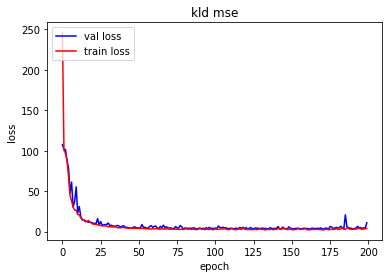

In [38]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

loss_ax.plot(hist.history['val_loss'], 'b', label='val loss')
loss_ax.plot(hist.history['loss'], 'r', label='train loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

plt.title('kld mse')
plt.show()

In [19]:
loaded_model = lstm_autoencoder

In [20]:
mean= 0
for xt in x_test:
    xt = xt.reshape(1, xt.shape[0], xt.shape[1])
    out = loaded_model.predict(xt)
    mean += ((xt-out)**2).mean(axis=None)
print(mean/len(x_test))

2.8633707719958217


In [4]:
filename = "last_mse_kld_lstmae"
# MODEL LOAD
loaded_model = model_from_json(open('res/kld/' +filename + '.json').read())
loaded_model.load_weights('res/kld/weights_' + filename + '.h5')

W1022 19:19:46.648915 140479360071424 deprecation_wrapper.py:119] From /home/minji/.local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1022 19:19:46.658055 140479360071424 deprecation_wrapper.py:119] From /home/minji/.local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1022 19:19:46.687883 140479360071424 deprecation_wrapper.py:119] From /home/minji/.local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1022 19:19:47.154119 140479360071424 deprecation_wrapper.py:119] From /home/minji/.local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:190: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.



In [ ]:
encoder = Model(loaded_model.input, loaded_model.layers[3].output)

In [ ]:
test = x_test[0].reshape(1, x_test[0].shape[0], x_test[0].shape[1])
latent_vector = []
for x in x_test:
    x = x.reshape(1, x.shape[0], x.shape[1])
    latent_vector.append(encoder.predict(x)[0])

In [23]:
model_path = 'model_save/mse_kld_models/weights' + '{epoch:02d}-{loss:.4f}.h5'
early_stopping_callback = EarlyStopping(monitor='loss', patience=200)
checkpoint_callback = ModelCheckpoint(model_path, monitor='loss', verbose = 1, save_best_only = True, save_weights_only = True, mode='min', period=100)

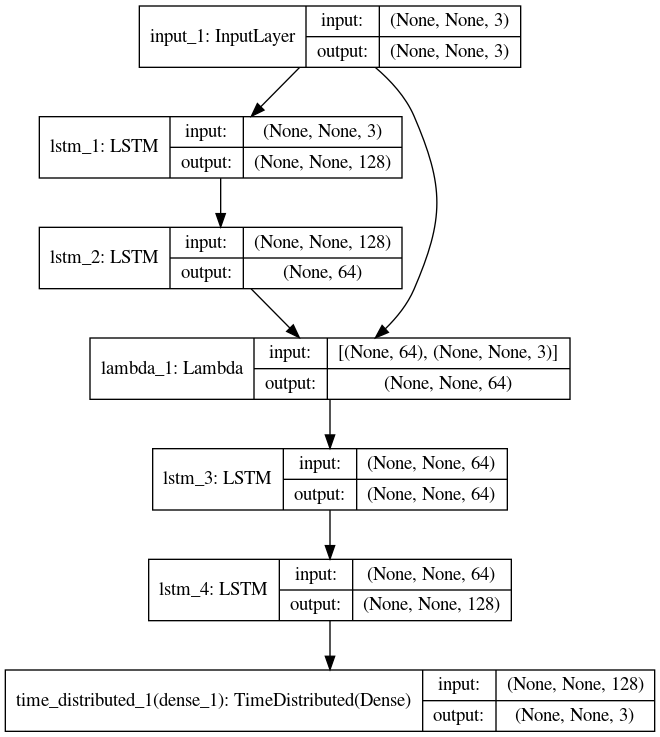

In [5]:
plot_model(loaded_model, to_file='./model.png', show_shapes=True, show_layer_names=True)